# Гибридный подход на примере Titanic

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import sys
import os
sys.path.append(os.path.abspath("..")) 
from utils.ModelAnalytic import ModelTester

C:\Users\79050\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  

In [4]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


Ограничим кол-во столбцов чтобы достовернее сравнить как нечеткие партиции влияют на качество модели

In [ ]:
df = df[['survived', 'age', 'fare']].dropna()
print('Оригинальные данные:\n', df.head(), '\n')

Оригинальные данные:
    survived   age     fare
0         0  22.0   7.2500
1         1  38.0  71.2833
2         1  26.0   7.9250
3         1  35.0  53.1000
4         0  35.0   8.0500 



## Нечеткая обработка (Fuzzy Transformation)
Составим нечеткие партции. Например, для признака `age` можно определить такие категории, как "young", "middle", "old". 


In [6]:
# Функция для вычисления нечеткого членства с использованием треугольной функции
def fuzzy_membership(series, params):
    return pd.Series(fuzz.trimf(series.values, params), index=series.index)

# Определяем нечеткие множества для 'age' и 'fare'
age_fuzzy = {'young': [0, 0, 30], 'middle': [20, 40, 60], 'old': [50, 100, 100]}
fare_fuzzy = {'low': [0, 0, 50], 'medium': [30, 100, 150], 'high': [100, 300, 300]}

for name, params in age_fuzzy.items():
    df[f'age_{name}'] = fuzzy_membership(df['age'], params)
for name, params in fare_fuzzy.items():
    df[f'fare_{name}'] = fuzzy_membership(df['fare'], params)

fuzzy_cols = [f'age_{k}' for k in age_fuzzy] + [f'fare_{k}' for k in fare_fuzzy]
print('Данные после нечеткой трансформации:\n', df.head(), '\n')

Данные после нечеткой трансформации:
    survived   age     fare  age_young  age_middle  age_old  fare_low  \
0         0  22.0   7.2500   0.266667        0.10      0.0    0.8550   
1         1  38.0  71.2833   0.000000        0.90      0.0    0.0000   
2         1  26.0   7.9250   0.133333        0.30      0.0    0.8415   
3         1  35.0  53.1000   0.000000        0.75      0.0    0.0000   
4         0  35.0   8.0500   0.000000        0.75      0.0    0.8390   

   fare_medium  fare_high  
0     0.000000        0.0  
1     0.589761        0.0  
2     0.000000        0.0  
3     0.330000        0.0  
4     0.000000        0.0   



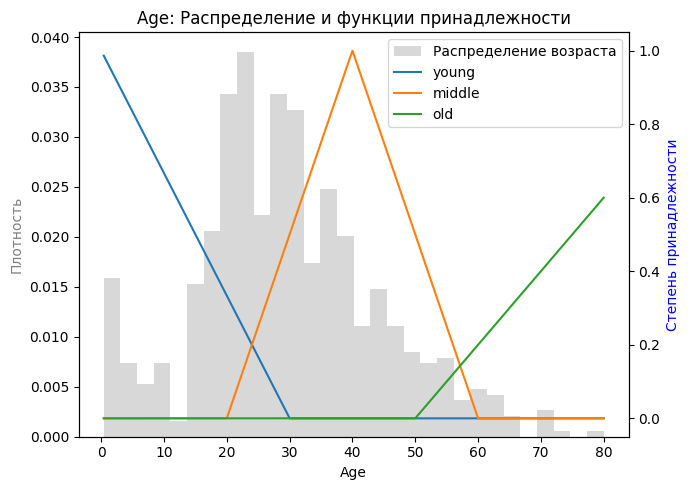

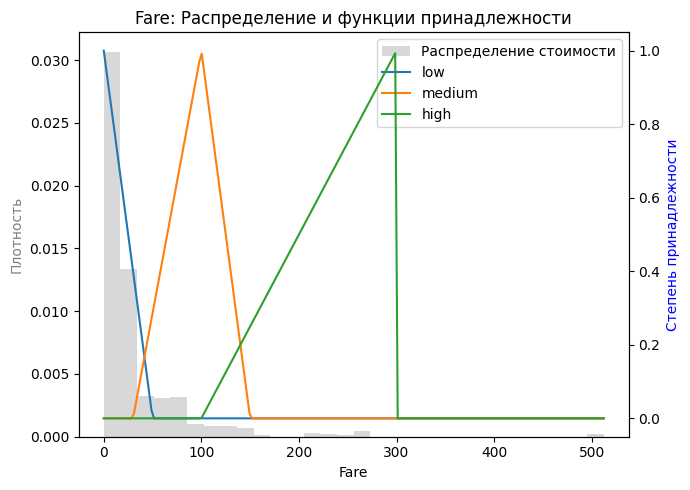

In [7]:
age_range = np.linspace(df['age'].min(), df['age'].max(), 200)
fare_range = np.linspace(df['fare'].min(), df['fare'].max(), 200)

fig_age, ax_age1 = plt.subplots(figsize=(7, 5))
ax_age1.hist(df['age'], bins=30, density=True, alpha=0.3, color='grey', label='Распределение возраста')
ax_age1.set_xlabel('Age')
ax_age1.set_ylabel('Плотность', color='grey')
ax_age2 = ax_age1.twinx()
for name, params in age_fuzzy.items():
    ax_age2.plot(age_range, fuzz.trimf(age_range, params), label=name)
ax_age2.set_ylabel('Степень принадлежности', color='blue')
lines, labels = ax_age1.get_legend_handles_labels()
lines2, labels2 = ax_age2.get_legend_handles_labels()
ax_age1.legend(lines + lines2, labels + labels2, loc='upper right')
ax_age1.set_title('Age: Распределение и функции принадлежности')
plt.tight_layout()
plt.show()

fig_fare, ax_fare1 = plt.subplots(figsize=(7, 5))
ax_fare1.hist(df['fare'], bins=30, density=True, alpha=0.3, color='grey', label='Распределение стоимости')
ax_fare1.set_xlabel('Fare')
ax_fare1.set_ylabel('Плотность', color='grey')
ax_fare2 = ax_fare1.twinx()
for name, params in fare_fuzzy.items():
    ax_fare2.plot(fare_range, fuzz.trimf(fare_range, params), label=name)
ax_fare2.set_ylabel('Степень принадлежности', color='blue')
lines, labels = ax_fare1.get_legend_handles_labels()
lines2, labels2 = ax_fare2.get_legend_handles_labels()
ax_fare1.legend(lines + lines2, labels + labels2, loc='upper right')
ax_fare1.set_title('Fare: Распределение и функции принадлежности')
plt.tight_layout()
plt.show()

## Кластеризация
После нечеткого преобразования каждая запись характеризуется вектором степеней принадлежности. Кластеризация группирует наблюдения с похожими профилями. Полученный кластер можно использовать как дополнительный признак в классификационной модели. Также интересно проверить, насколько кластеризация внесет "пользу в решение модели"


In [8]:
fuzzy_matrix = df[fuzzy_cols].values
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(fuzzy_matrix)
print('Данные после кластеризации:\n', df.head(), '\n')

Данные после кластеризации:
    survived   age     fare  age_young  age_middle  age_old  fare_low  \
0         0  22.0   7.2500   0.266667        0.10      0.0    0.8550   
1         1  38.0  71.2833   0.000000        0.90      0.0    0.0000   
2         1  26.0   7.9250   0.133333        0.30      0.0    0.8415   
3         1  35.0  53.1000   0.000000        0.75      0.0    0.0000   
4         0  35.0   8.0500   0.000000        0.75      0.0    0.8390   

   fare_medium  fare_high  cluster  
0     0.000000        0.0        1  
1     0.589761        0.0        0  
2     0.000000        0.0        2  
3     0.330000        0.0        0  
4     0.000000        0.0        2   




## Сравнение моделей

- **Обычное дерево классификации** – использует только исходные числовые признаки.
- **Гибридная модель** – использует исходные признаки + кластер + вектора степеней пренодлежностей

In [9]:
features_conv = ['age', 'fare']
features_hybrid = features_conv + fuzzy_cols +['cluster']
y = df['survived']

X_conv = df[features_conv]
X_hybrid = df[features_hybrid]

X_train_conv, X_test_conv, y_train, y_test = train_test_split(X_conv, y, test_size=0.2, random_state=42)
X_train_hybrid = X_hybrid.loc[X_train_conv.index]
X_test_hybrid = X_hybrid.loc[X_test_conv.index]


# Модель A: Обычное дерево классификации
dt_conv = DecisionTreeClassifier(random_state=42)
dt_conv.fit(X_train_conv, y_train)
y_pred_conv = dt_conv.predict(X_test_conv)
print('Conventional Decision Tree:\n', classification_report(y_test, y_pred_conv))

# Модель B: Гибридная модель 
dt_hybrid = DecisionTreeClassifier(random_state=42)
dt_hybrid.fit(X_train_hybrid, y_train)
y_pred_hybrid = dt_hybrid.predict(X_test_hybrid)
print('Hybrid Fuzzy-Clustering Decision Tree:\n', classification_report(y_test, y_pred_hybrid))

Conventional Decision Tree:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69        87
           1       0.52      0.50      0.51        56

    accuracy                           0.62       143
   macro avg       0.60      0.60      0.60       143
weighted avg       0.62      0.62      0.62       143

Hybrid Fuzzy-Clustering Decision Tree:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72        87
           1       0.55      0.50      0.52        56

    accuracy                           0.64       143
   macro avg       0.62      0.62      0.62       143
weighted avg       0.64      0.64      0.64       143



In [10]:
conv_tester = ModelTester(categorical=[],numeric=['age','fare'], target='survived')

              Metric   Results
0           Accuracy  0.904762
1  Balanced Accuracy  0.897471
2          Precision  0.902174
3             Recall  0.858621
4                 F1  0.879859
5            LogLoss  2.659758
6            roc-auc  0.919490
----------- Feature Importance -----------
fare: 0.5873
age: 0.4127


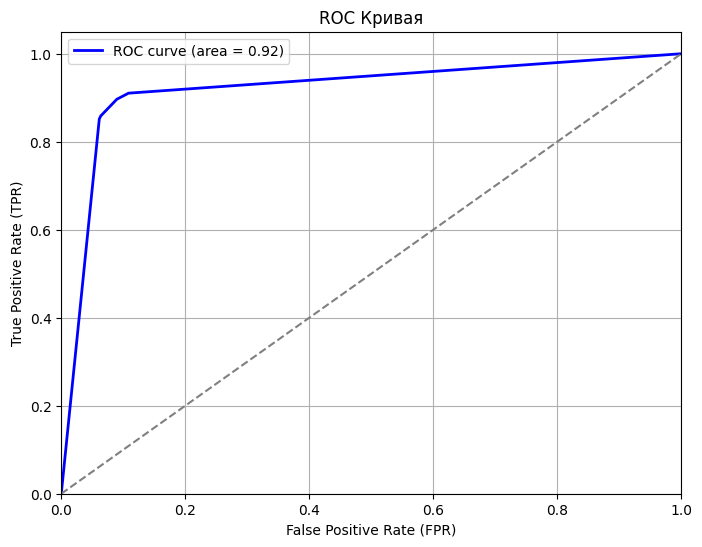

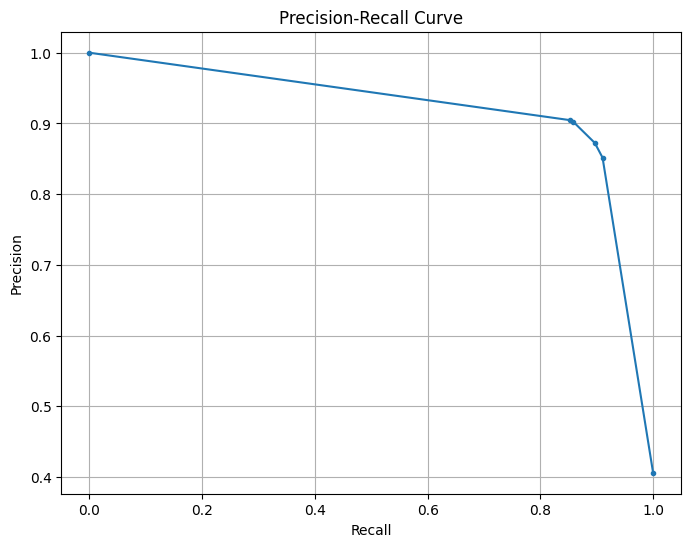

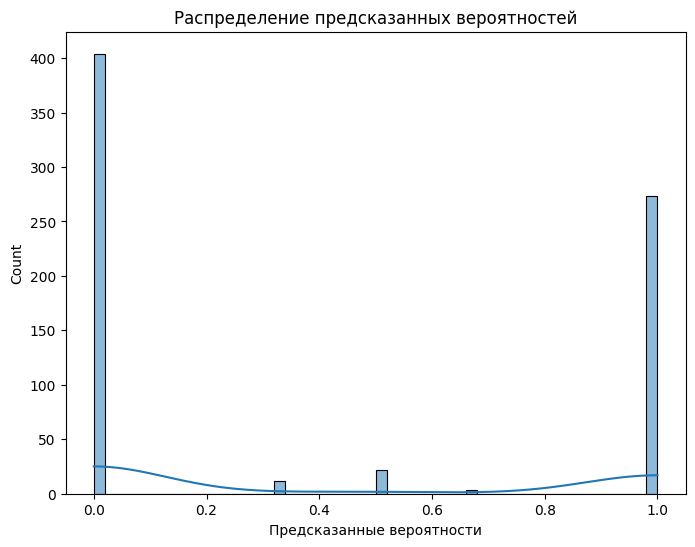

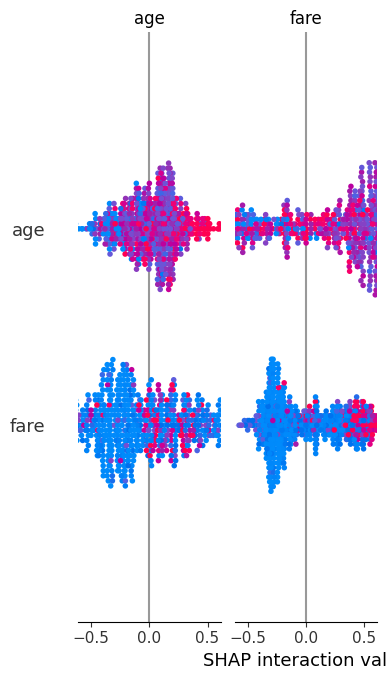

In [11]:
conv_tester.run(dt_conv,df)

In [12]:
hybrid_tester = ModelTester(categorical=['cluster'],numeric=features_conv + fuzzy_cols, target='survived')

              Metric   Results
0           Accuracy  0.908964
1  Balanced Accuracy  0.901008
2          Precision  0.912088
3             Recall  0.858621
4                 F1  0.884547
5            LogLoss  2.458803
6            roc-auc  0.924894
----------- Feature Importance -----------
age: 0.3772
cluster: 0.2463
age_old: 0.1390
age_young: 0.0961
fare: 0.0704
fare_low: 0.0299
fare_high: 0.0159
fare_medium: 0.0141
age_middle: 0.0111


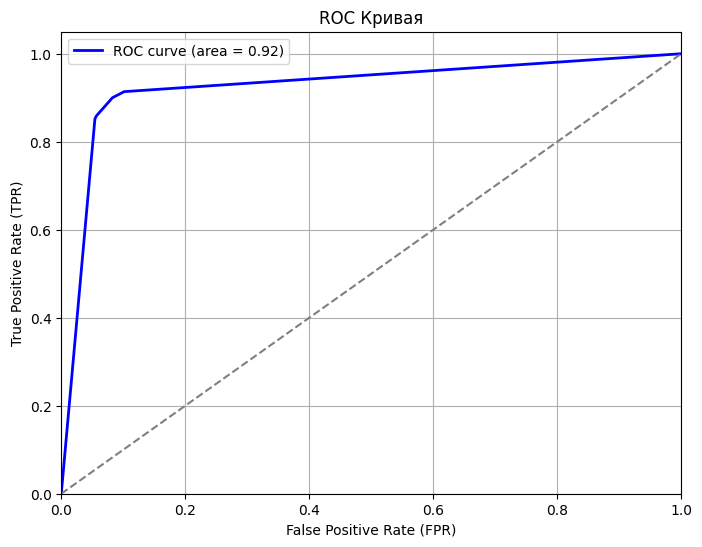

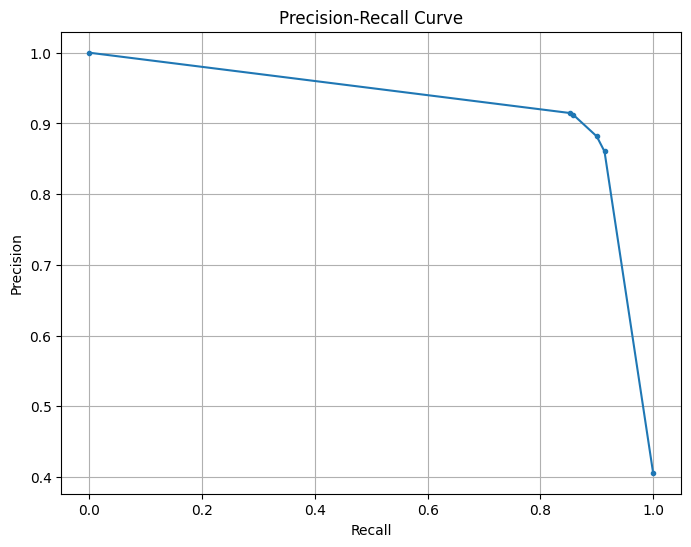

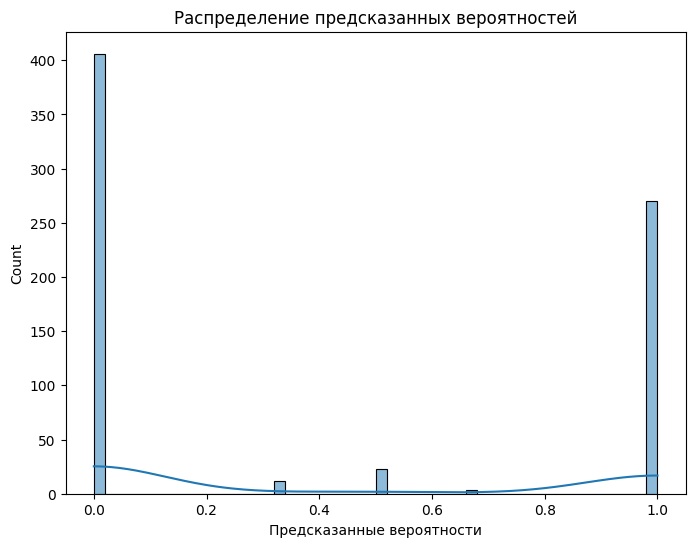

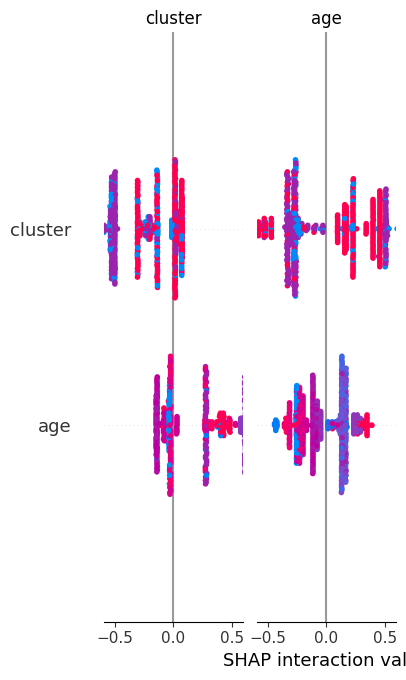

In [13]:
hybrid_tester.run(dt_hybrid,df)

## Вывод

На очень ограниченной выборке данных и наборе фичей, просто сами нечеткие преобразования над данными смогли увеличить основные метрики (Precission, Recall, F1-score), т.е. модель смогла найти дополнительные закономерности данных

P.s. графики класса ModelTester не сильно информативны для такой слабой модели и такого слабого датасета, их лучше убрать, заменив метод run на metrics